# Combine Numeric and Categorical Features

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
def read_df(filename, valtype):
    df = pd.read_csv(filename, low_memory=False, dtype=valtype)
    return df

In [5]:
from collections import OrderedDict, defaultdict

def create_combined_df(input_dict):
    fdf = pd.DataFrame()
    cols = OrderedDict()
    for k, v in input_dict.items():
        df = read_df('./data/'+k, v)
        colnames = [c for c in df.columns if c not in ['None', 'Unnamed: 0']]
        cols[k] = colnames
        fdf = pd.concat([fdf, df], axis=1)
    
    # fdf = fdf.DataFrame(fdf, columns=cols)
    fdf = fdf.drop(['None', 'Unnamed: 0'], axis=1)
    return fdf, cols

# Read Dependent feature data

In [6]:
y_train = pd.read_csv('./data/fin_train_indeps.csv', encoding='utf8')
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_train.sample()

,review_scores_rating
62932,100.0


In [7]:
np.unique(y_train)

array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])

In [8]:
y_test = pd.read_csv('./data/fin_test_indeps.csv', encoding='utf8')
y_test = y_test.drop(['Unnamed: 0'], axis=1)
y_test.sample()

,review_scores_rating
433,98.0


In [9]:
np.unique(y_test)

array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])

# Read independent feature data

In [10]:
num_train = pd.read_csv('./data/fin_num_train_deps.csv')
num_train = num_train.drop(['Unnamed: 0'], axis=1)
num_test = pd.read_csv('./data/fin_num_test_deps.csv')
num_test = num_test.drop(['Unnamed: 0'], axis=1)

cat_train = pd.read_csv('./data/fin_cat_train_deps.csv')
cat_train = cat_train.drop(['Unnamed: 0'], axis=1)
cat_test = pd.read_csv('./data/fin_cat_test_deps.csv')
cat_test = cat_test.drop(['Unnamed: 0'], axis=1)

amen_train = pd.read_csv('./data/fin_amen_train_deps.csv')
amen_train = amen_train.drop(['Unnamed: 0'], axis=1)
amen_test = pd.read_csv('./data/fin_amen_test_deps.csv')
amen_test = amen_test.drop(['Unnamed: 0'], axis=1)

In [11]:
comb_train = pd.read_csv('./data/fin_comb_train_deps.csv')
comb_train = comb_train.drop(['Unnamed: 0'], axis=1)
comb_test = pd.read_csv('./data/fin_comb_test_deps.csv')
comb_test = comb_test.drop(['Unnamed: 0'], axis=1)

# Split Test data into Holdout and Validation sets

In [12]:
np.random.seed(1234)
idxs = np.random.randint(0, y_test.shape[0], y_test.shape[0]//2)

In [13]:
y_validation = y_test.iloc[~y_test.index.isin(idxs)]
y_holdout = y_test.iloc[idxs]

In [14]:
num_validation = num_test.iloc[~num_test.index.isin(idxs)]
num_holdout = num_test.iloc[idxs]

cat_validation = cat_test.iloc[~cat_test.index.isin(idxs)]
cat_holdout = cat_test.iloc[idxs]

amen_validation = amen_test.iloc[~amen_test.index.isin(idxs)]
amen_holdout = amen_test.iloc[idxs]

comb_validation = comb_test.iloc[~comb_test.index.isin(idxs)]
comb_holdout = comb_test.iloc[idxs]

In [15]:
def run_model(X, y, Xt, yt, model):
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    if len(yt.shape) == 1:
        yt = yt.reshape(-1, 1)
    
    res = {'train': {}, 'test': {}}
    
    model.fit(X, y)
    
    train_pred = model.predict(X)
    res['train']['pred'] = train_pred
    
    test_pred = model.predict(Xt)
    res['test']['pred'] = test_pred
    
    for name, tup in zip(['train', 'test'], [(y, train_pred), (yt, test_pred)]):
        act = tup[0].values 
        prd = tup[1].ravel()
        
        mserr = mean_squared_error(act, prd)
        res[name]['mse'] = mserr
        
        rsq_score = r2_score(act, prd)
        res[name]['r2'] = rsq_score
    
    return model, res

In [16]:
def run_model_resgen(X, y, Xt, yt, model, sample_sizes=[]):
    for ss in sample_sizes:
        np.random.seed(1234)
        rand_idxs = np.random.randint(0, X.shape[0], size=ss)
        Xs = X.iloc[rand_idxs]
        ys = y.iloc[rand_idxs]
        
        yield run_model(Xs, ys, Xt, yt, model)

In [17]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

sample_sizes = [i for i in range(1000, num_train.shape[0] // 10, 2500)] # + [num_train.shape[0]]

regr = linear_model.Lasso(alpha=0.001, fit_intercept=True, max_iter=10000)


def plot_model_results(X, y, Xt, yt, model, sample_sizes):
    mse_train = []
    mse_test = []
    r2_train = []
    r2_test = []

    for _, r in run_model_resgen(X, y, Xt, yt, model, sample_sizes):
        mse_train.append(r['train']['mse'])
        mse_test.append(r['test']['mse'])        
        r2_train.append(r['train']['r2'])
        r2_test.append(r['test']['r2'])        
    
    
    
    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(111)
    alph = 0.75
    ln1 = ax1.plot(sample_sizes, mse_train, 'b-', color='b', alpha=alph, label='Train MSE')
    ln2 = ax1.plot(sample_sizes, mse_test, 'b--', color='b', alpha=alph, label='Test MSE')
    ax1.set_xlabel('sample size')
    ax1.set_ylabel('MSE', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ln3 = ax2.plot(sample_sizes, r2_train, 'g-', color='g', alpha=alph, label='Train R2')
    ln4 = ax2.plot(sample_sizes, r2_test, 'g--', color='g', alpha=alph, label='Test R2')
    ax2.set_ylabel('R2', color='g')
    ax2.tick_params('y', colors='g')
    
    lns = ln1 + ln2 + ln3 + ln4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs)
    
    # fig.tight_layout()
    # plt.legend()
    plt.title('Train and Test MSE and R2 vs. sample size') 
    plt.show()
    
    model = _ # Just the final model
    return model

In [18]:
import xgboost
from vecstack import StackingTransformer
from vecstack import stacking
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

def rmse(train, pred):
    return mean_squared_error(train, pred)


def rsq(train, pred):
    return r2_score(train, pred)

lass = Lasso(alpha=0.001, fit_intercept=False, max_iter=1000)

ridge = Ridge(normalize=False, alpha=0.001, max_iter=1000)

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, 
                               subsample=0.75, max_depth=15)

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, 
                           gamma=0, subsample=0.5, colsample_bytree=0.5, 
                           max_depth=15, objective='reg:linear')

randf = RandomForestRegressor(n_estimators=100, min_samples_split=10)

svr_rbf = SVR(kernel='rbf')


estimators = [
              ('gbf', GradientBoostingRegressor(alpha=0.001)), 
              ('randf', randf), 
             ]

stack = StackingTransformer(estimators, regression=True, 
                            shuffle=True, n_folds=10, 
                            metric=rmse, verbose=2, 
                           )

stack = stack.fit(comb_train, y_train)

/Users/jhabib/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


task:         [regression]
metric:       [rmse]
variant:      [A]
n_estimators: [2]

estimator  0: [gbf: GradientBoostingRegressor]
    fold  0:  [21.23945467]
    fold  1:  [20.76586612]
    fold  2:  [21.17541615]
    fold  3:  [20.75589301]
    fold  4:  [21.29169119]
    fold  5:  [21.07909745]
    fold  6:  [20.66629099]
    fold  7:  [21.37865229]
    fold  8:  [21.20093126]
    fold  9:  [20.63771908]
    ----
    MEAN:     [21.01910122] + [0.26768787]

estimator  1: [randf: RandomForestRegressor]
    fold  0:  [6.71063206]
    fold  1:  [6.00937631]
    fold  2:  [6.17470635]
    fold  3:  [6.45418212]
    fold  4:  [6.51273145]
    fold  5:  [6.30682018]
    fold  6:  [6.06605726]
    fold  7:  [7.04123697]
    fold  8:  [6.45738348]
    fold  9:  [6.27281665]
    ----
    MEAN:     [6.40059428] + [0.29433493]

Train set was detected.
Transforming...

estimator  0: [gbf: GradientBoostingRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2

In [19]:
# Get stacked features
S_train = stack.transform(comb_train)
S_test = stack.transform(comb_validation)

# Use 2nd level estimator on Stacked data
# model = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.05)
model = xgb

model.fit(S_train, y_train)

y_train_pred = model.predict(S_train)

# Make predictions using the testing set
y_pred = model.predict(S_test)

Transforming...

estimator  0: [gbf: GradientBoostingRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  1: [randf: RandomForestRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE



In [26]:
# The mean squared error
print("Train Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_pred))
# Explained variance score: 1 is perfect prediction
print 'Train Variance score: %.2f' % r2_score(y_train, y_train_pred) 


Train Mean squared error: 5.40
Train Variance score: 0.79


In [24]:
# The mean squared error
print("Validation Mean squared error: %.2f"
      % mean_squared_error(y_validation, y_pred))
# Explained variance score: 1 is perfect prediction
print 'Validation Variance score: %.2f' % r2_score(y_validation, y_pred) 


Validation Mean squared error: 6.27
Validation Variance score: 0.75


In [1]:
print type(y_train)

NameError: name 'y_train' is not defined

In [ ]:
np.subtract(y_train, y_train_pred)

train residuals:


ValueError: x and y must be the same size

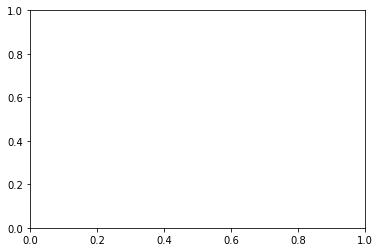

In [34]:
# Plot the residuals
print 'train residuals:'
plt.scatter(y_train.values, , c='b', marker='o', alpha=0.5)
plt.show()


In [ ]:
def wrap_vec_stack(X, y, Xt, yt, sample_sizes, sstack, mmodel):

    for ss in sample_sizes:
        np.random.seed(1234)
        rand_idxs = np.random.randint(0, X.shape[0], size=ss)
        Xs = X.iloc[rand_idxs]
        ys = y.iloc[rand_idxs]

        stack = sstack.fit(Xs, ys)
        
        # Get stacked features
        S_train = stack.transform(Xs)
        S_test = stack.transform(Xt)

        # Use 2nd level estimator on Stacked data
        # model = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.05)
        model = mmodel
        plot_model_results(Xs, ys, Xt, yt, model, [ss])


# wrap_vec_stack(comb_train, y_train, comb_validation, y_validation, sample_sizes, stack, xgb)